In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
import torch

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [2]:
data_dir = Path('../input/playground-series-s3e16')
train = pd.read_csv(data_dir/'train.csv', index_col=None)
test = pd.read_csv(data_dir/'test.csv', index_col=None)
submission = pd.read_csv(data_dir/'sample_submission.csv')

target = 'Age'

In [3]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [4]:
test.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


In [5]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Blue'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

def check_data(data, title):
    cols = data.columns.to_list()
    display(set_frame_style(data[cols].head(),f'{title}: First 5 Rows Of Data'))
    display(set_frame_style(data[cols].describe(),f'{title}: Summary Statistics'))
    display(set_frame_style(data[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), f'{title}: Unique Value Counts In Each Column'))
    display(set_frame_style(data[cols].isna().sum().to_frame().transpose(), f'{title}:Columns With Nan'))
    
check_data(train, 'Train data')
print('-'*100)
check_data(test, 'Test data')

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.525000,1.175000,0.375000,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.100000,0.825000,0.275000,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.387500,1.112500,0.375000,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.700000,1.412500,0.500000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.250000,1.012500,0.337500,23.289114,11.977664,4.507570,5.953395,8


,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,37025.000000,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,21376.826729,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,18512.500000,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,37025.000000,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,55537.500000,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,74050.000000,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
Unique Value Count,74051,3,144,122,65,3096,1766,967,1048,28


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,0,0,0,0,0,0,0,0,0


----------------------------------------------------------------------------------------------------


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,I,1.050000,0.762500,0.275000,8.618248,3.657085,1.729319,2.721552
1,74052,I,1.162500,0.887500,0.275000,15.507176,7.030676,3.246018,3.968930
2,74053,F,1.287500,0.987500,0.325000,14.571643,5.556502,3.883882,4.819415
3,74054,F,1.550000,0.987500,0.387500,28.377849,13.380964,6.548735,7.030676
4,74055,I,1.112500,0.850000,0.262500,11.765042,5.528153,2.466407,3.331066


,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
count,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000,49368.000000
mean,98734.500000,1.319795,1.026357,0.348693,23.464627,10.130220,5.072615,6.745876
std,14251.458382,0.286950,0.236593,0.092259,12.641703,5.611779,2.791563,3.575650
min,74051.000000,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524
25%,86392.750000,1.162500,0.887500,0.300000,13.536886,5.740774,2.877474,3.968930
50%,98734.500000,1.387500,1.075000,0.362500,23.813580,9.979024,4.989512,6.945627
75%,111076.250000,1.537500,1.200000,0.412500,32.290081,14.047177,7.016501,9.171063
max,123418.000000,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
Unique Value Count,49368,3,140,122,57,2948,1692,938,987


,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,0,0,0,0,0,0,0,0,0


In [6]:
num_cols = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight']
target_col = 'Age'

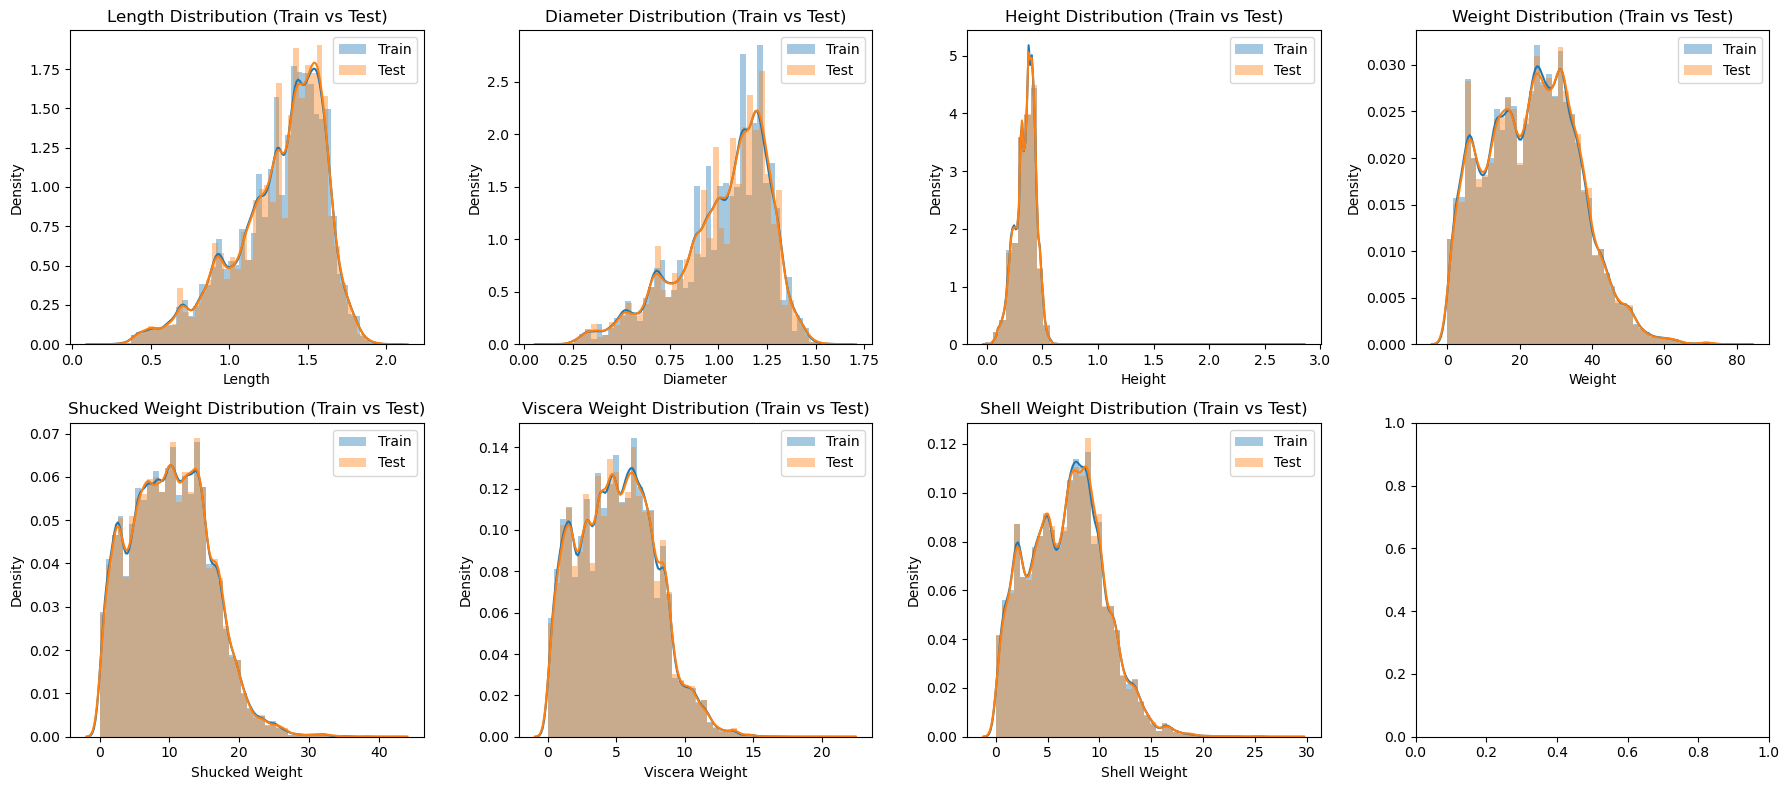

In [7]:
def plot_histograms(df_train, df_test, target_col, n_cols=3):
    n_rows = (len(df_train.columns) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()

    for i, var_name in enumerate(df_train.columns.tolist()):
        if var_name != 'is_generated':
            ax = axes[i]
            sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
            if var_name != target_col:
                sns.distplot(df_test[var_name], kde=True, ax=ax, label='Test')
            ax.set_title(f'{var_name} Distribution (Train vs Test)')
            ax.legend()

    plt.tight_layout()
    plt.show()
        
plot_histograms(train[num_cols], test[num_cols], target_col, n_cols=4)

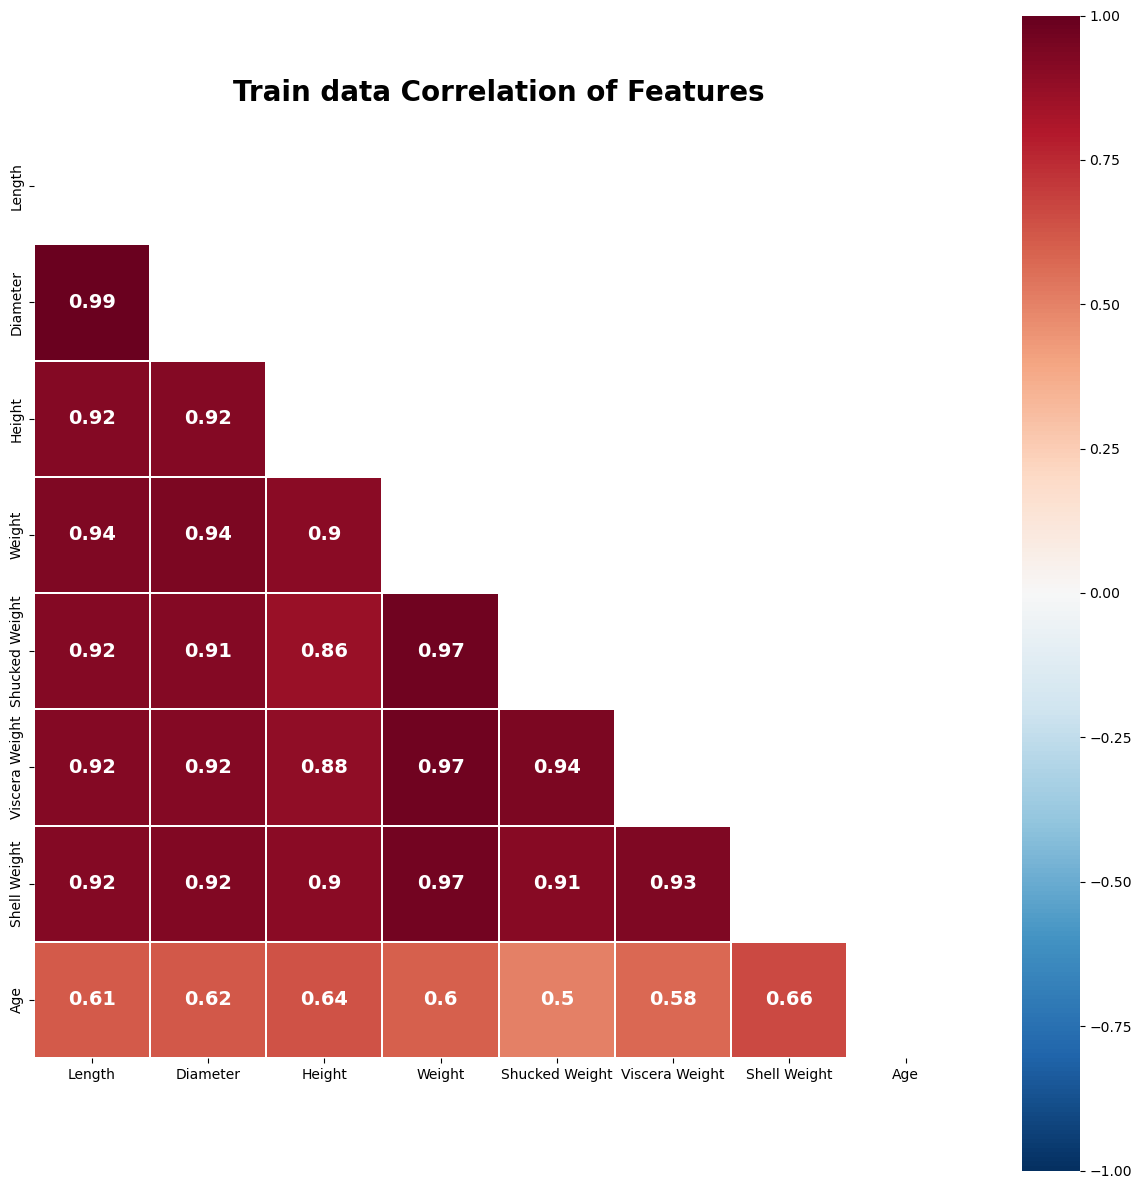

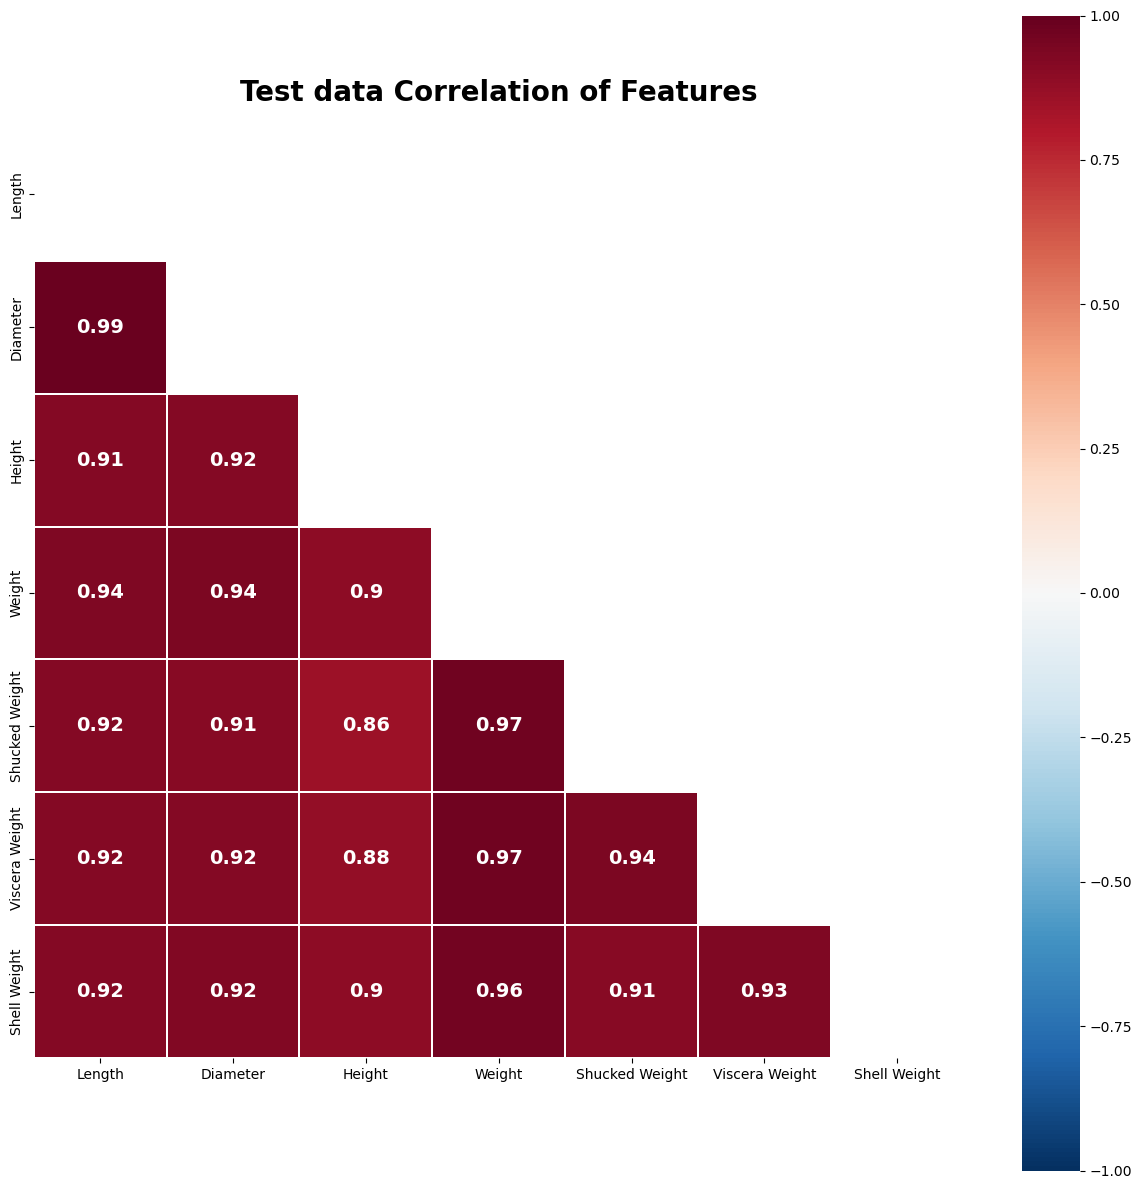

In [8]:
def plot_heatmap(df, title):
    # Create a mask for the diagonal elements
    mask = np.zeros_like(df.astype(float).corr())
    mask[np.triu_indices_from(mask)] = True

    # Set the colormap and figure size
    colormap = plt.cm.RdBu_r
    plt.figure(figsize=(15, 15))

    # Set the title and font properties
    plt.title(f'{title} Correlation of Features', fontweight='bold', y=1.02, size=20)

    # Plot the heatmap with the masked diagonal elements
    sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 14, "weight": "bold"},
                mask=mask)

plot_heatmap(train[num_cols+[target_col]], title='Train data')
plot_heatmap(test[num_cols], title='Test data')

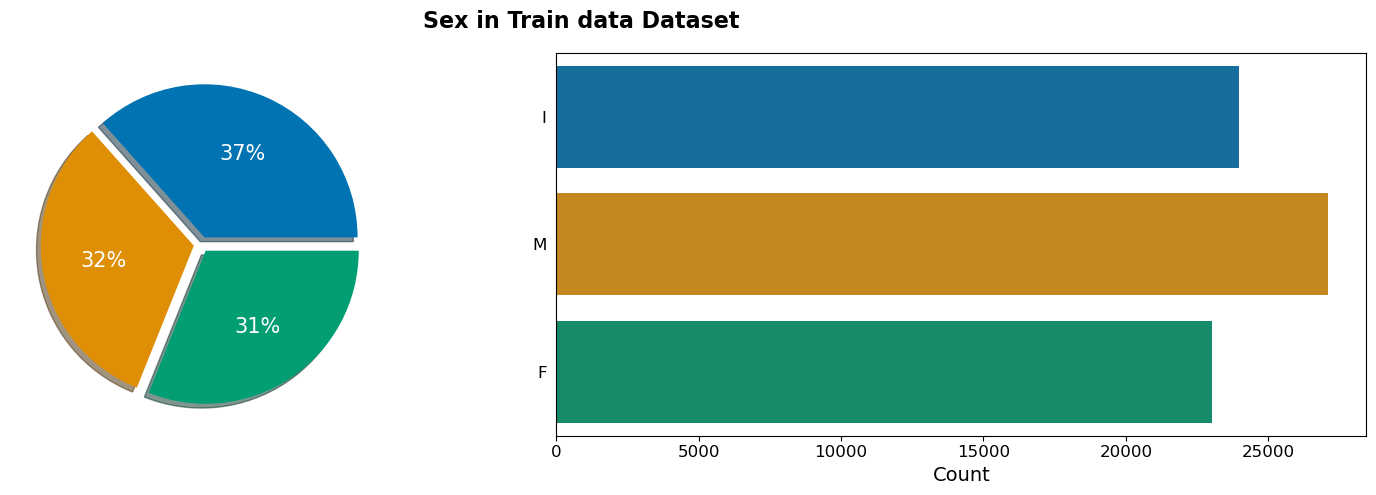

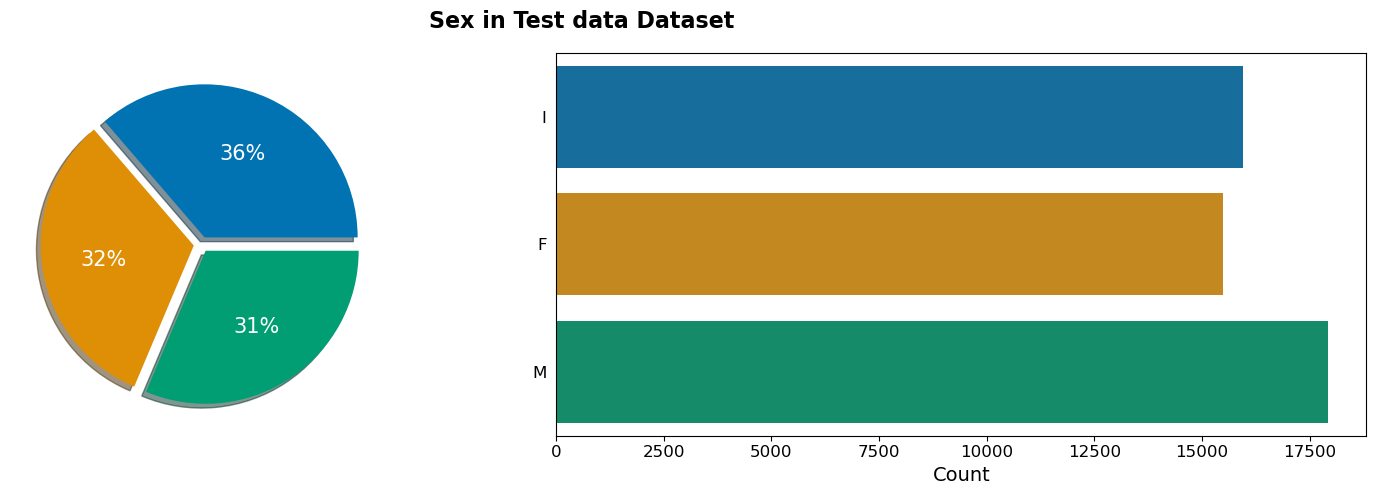

In [9]:
def plot_target_feature(df_train, target_col, figsize=(16,5), palette='colorblind', name='Train'):
    df_train = df_train.fillna('Nan')

    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax = ax.flatten()

    # Pie chart
    pie_colors = sns.color_palette(palette, len(df_train[target_col].unique()))
    ax[0].pie(
        df_train[target_col].value_counts(),
        shadow=True,
        explode=[0.05] * len(df_train[target_col].unique()),
        autopct='%1.f%%',
        textprops={'size': 15, 'color': 'white'},
        colors=pie_colors
    )
    ax[0].set_aspect('equal')  # Fix the aspect ratio to make the pie chart circular

    # Bar plot
    bar_colors = sns.color_palette(palette)
    sns.countplot(
        data=df_train,
        y=target_col,
        ax=ax[1],
        palette=bar_colors
    )
    ax[1].set_xlabel('Count', fontsize=14)
    ax[1].set_ylabel('')
    ax[1].tick_params(labelsize=12)
    ax[1].yaxis.set_tick_params(width=0)  # Remove tick lines for y-axis

    fig.suptitle(f'{target_col} in {name} Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Show the plot
    plt.show()
    
plot_target_feature(train, 'Sex', figsize=(16,5), palette='colorblind', name='Train data')
plot_target_feature(test, 'Sex', figsize=(16,5), palette='colorblind', name='Test data')

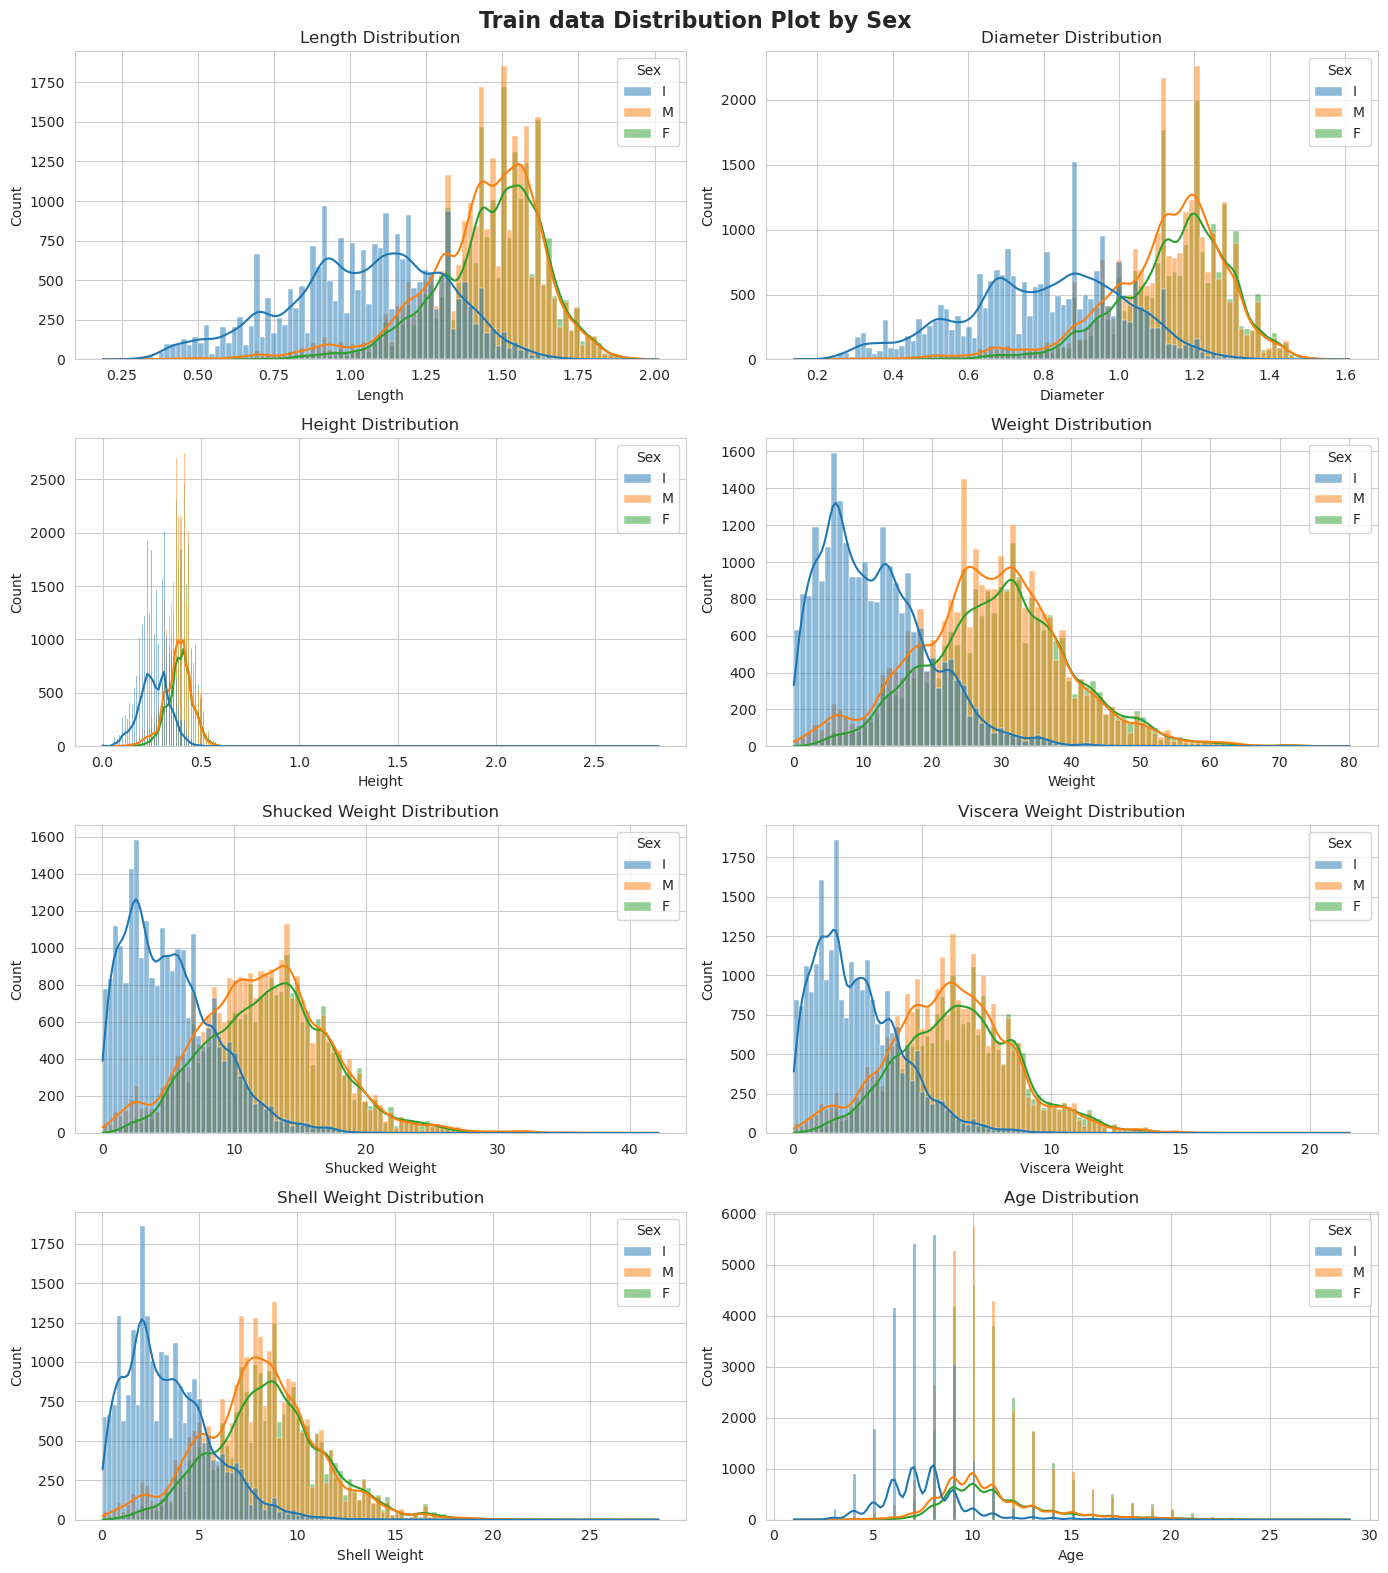

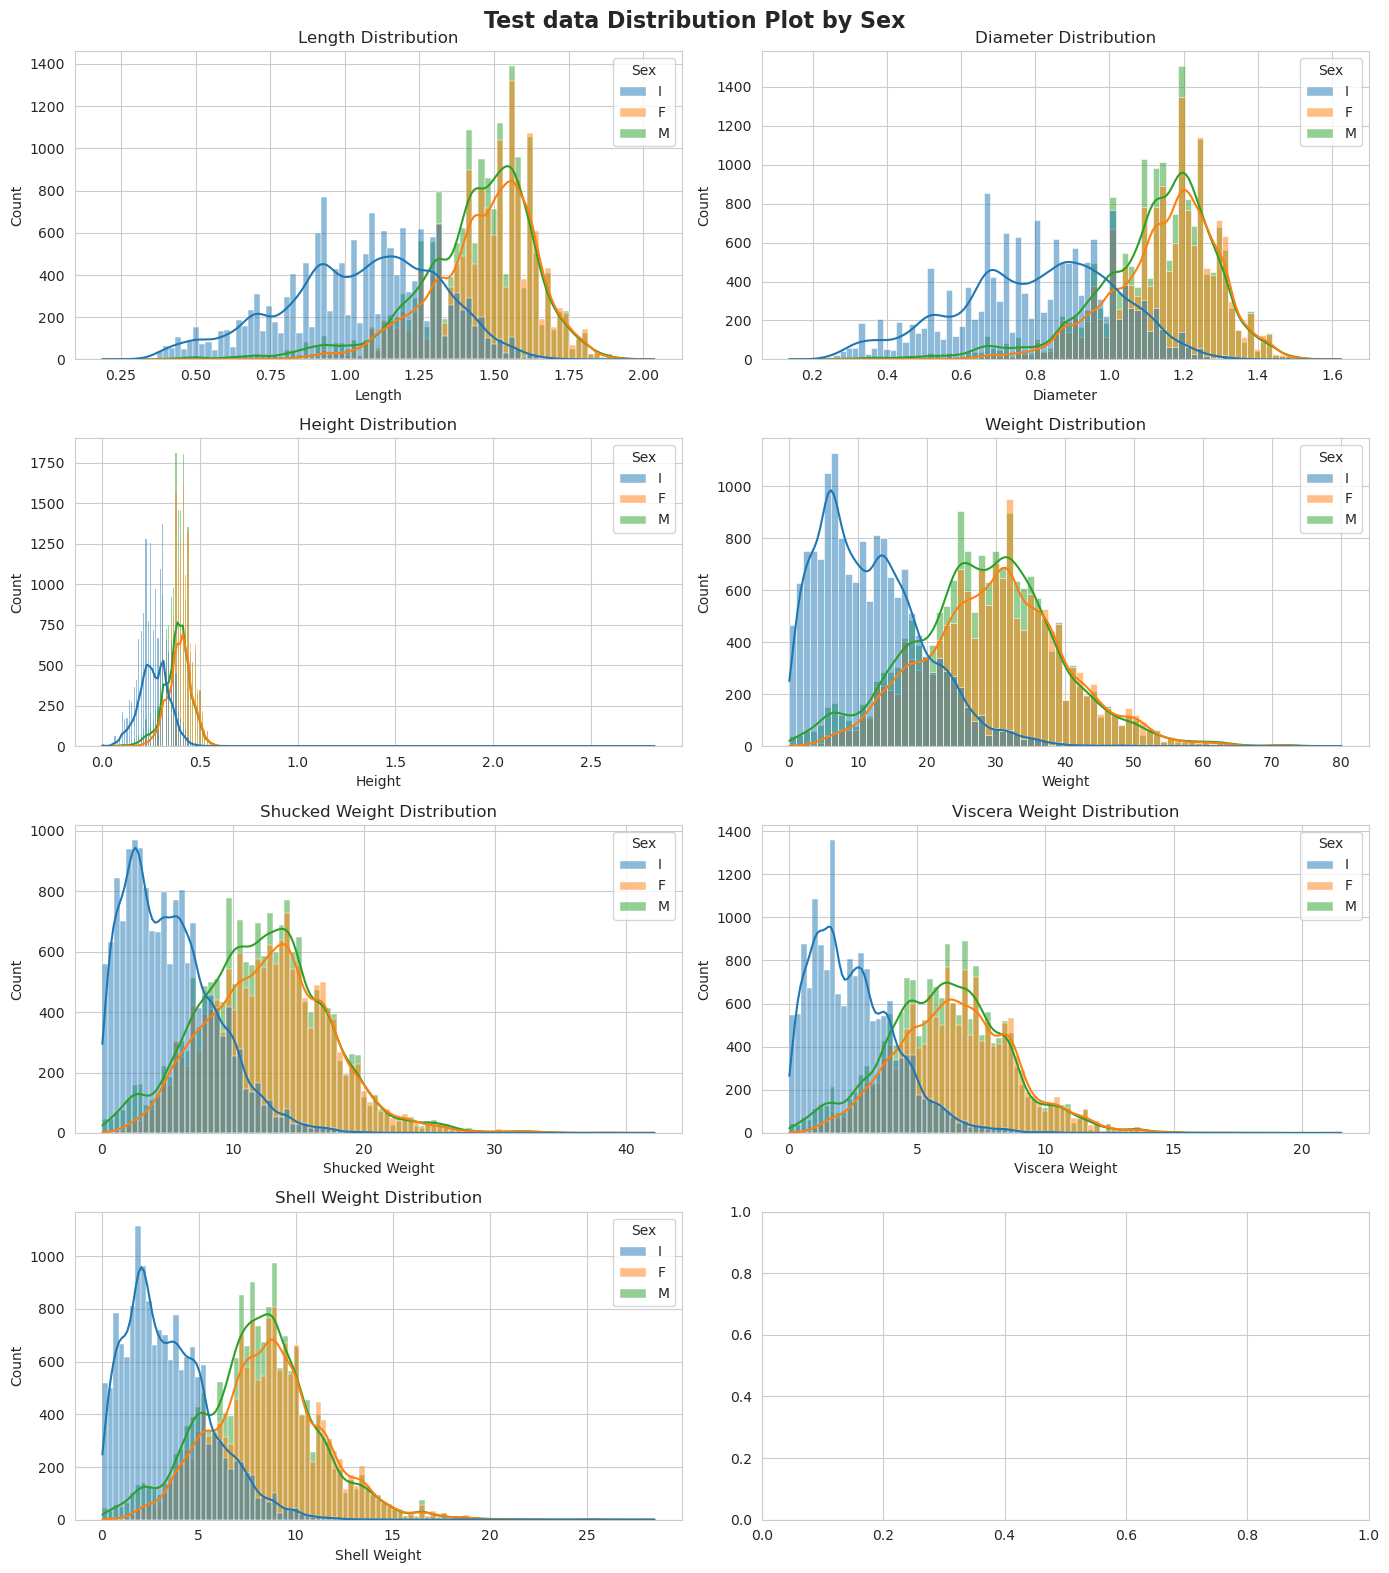

In [10]:
def plot_distribution(df, hue, title=''):
    sns.set_style('whitegrid')

    cols = df.columns.drop([hue])
    n_cols = 2
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols

        ax = axes[row, col]
        sns.histplot(data=df, x=var_name, kde=True, ax=ax, hue=hue) # sns.distplot(df_train[var_name], kde=True, ax=ax, label='Train')
        ax.set_title(f'{var_name} Distribution')

    fig.suptitle(f'{title} Distribution Plot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_distribution(train[num_cols + ['Age', 'Sex']], hue='Sex', title='Train data')
plot_distribution(test[num_cols + ['Sex']], hue='Sex', title='Test data')

In [11]:
from scipy.stats import boxcox,boxcox_normplot
from scipy import stats

In [12]:
def reciprocal(x):
    return 1 / x

In [13]:
colss = ['Length', 'Diameter', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight']
def best_param_gaussian(df, title=''):
    
    dfc = df.copy()

    for i, var_name in enumerate(colss):

        orig = dfc[var_name].values
        orig_trans, lmbda = boxcox(orig)
        print(f'Best lambda parameter of {var_name} = {round(lmbda, 3)}')

        orig.sort()
        mean, std = stats.norm.fit(orig_trans, loc=0)
        pdf_norm = stats.norm.pdf(orig_trans, mean, std)

        
        dfc[var_name] = orig_trans
    
    return dfc
    
train[colss] = best_param_gaussian(train[colss],  title='Train data')
test[colss] = best_param_gaussian(test[colss],  title='Test data')

Best lambda parameter of Length = 2.291
Best lambda parameter of Diameter = 2.168
Best lambda parameter of Weight = 0.708
Best lambda parameter of Shucked Weight = 0.669
Best lambda parameter of Viscera Weight = 0.679
Best lambda parameter of Shell Weight = 0.709
Best lambda parameter of Length = 2.31
Best lambda parameter of Diameter = 2.183
Best lambda parameter of Weight = 0.71
Best lambda parameter of Shucked Weight = 0.671
Best lambda parameter of Viscera Weight = 0.68
Best lambda parameter of Shell Weight = 0.715


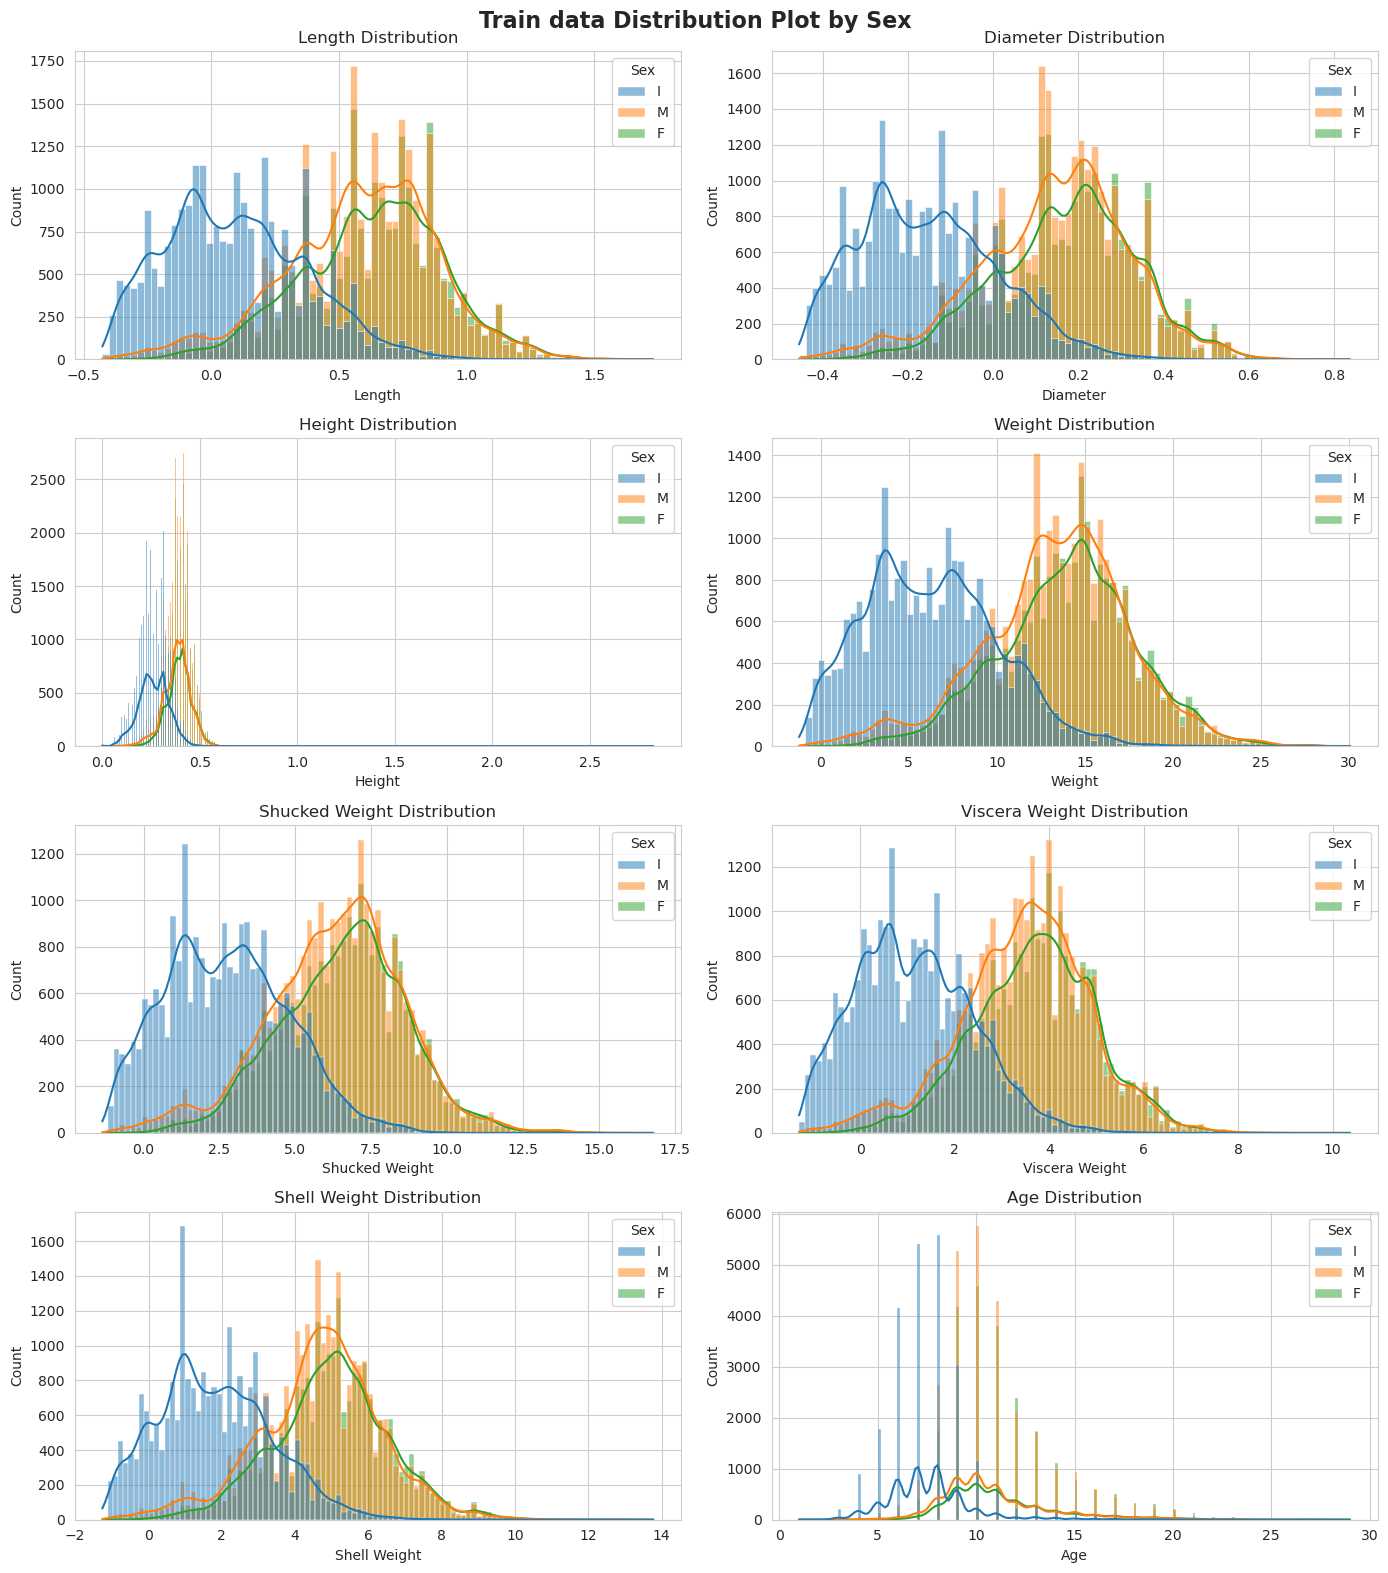

In [14]:
plot_distribution(train[num_cols + ['Age', 'Sex']], hue='Sex', title='Train data')

In [15]:
enc = OneHotEncoder() 
ohe_train = pd.DataFrame(enc.fit_transform(train[['Sex']]).toarray(), columns=enc.get_feature_names_out())
train.drop('Sex', axis=1, inplace=True)
train = pd.concat([train, ohe_train], axis=1)

ohe_test = pd.DataFrame(enc.transform(test[['Sex']]).toarray(), columns=enc.get_feature_names_out())
test.drop('Sex', axis=1, inplace=True)
test = pd.concat([test, ohe_test], axis=1)

features = train.columns.drop(['id', target]).to_list()

In [16]:
train

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,0,0.711204,0.193047,0.3750,13.898299,6.702650,3.856563,4.943000,9,0.0,1.0,0.0
1,1,0.106515,-0.157303,0.2750,6.009795,2.607014,1.138641,1.950300,8,0.0,1.0,0.0
2,2,0.487820,0.119934,0.3750,12.293203,6.092800,3.245662,4.003058,9,0.0,0.0,1.0
3,3,1.035498,0.513952,0.5000,21.327698,9.727246,6.024863,8.215868,11,1.0,0.0,0.0
4,4,0.291272,0.012591,0.3375,11.705124,6.375734,2.620924,3.587913,8,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
74046,74046,0.962172,0.303287,0.4375,21.327698,9.847175,5.730339,6.968390,10,1.0,0.0,0.0
74047,74047,0.078656,-0.126550,0.2750,6.024087,2.485692,1.116977,2.049032,6,0.0,1.0,0.0
74048,74048,0.647576,0.223602,0.4125,14.088714,6.518413,4.332645,4.796921,10,1.0,0.0,0.0
74049,74049,0.242221,-0.036681,0.3125,8.983505,4.992694,1.575850,2.545231,8,0.0,1.0,0.0


In [17]:
test

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,74051,0.051645,-0.204650,0.2750,5.093482,2.066573,0.663655,1.462677,0.0,1.0,0.0
1,74052,0.180073,-0.105068,0.2750,8.459882,4.023727,1.804327,2.348513,0.0,1.0,0.0
2,74053,0.343157,-0.012408,0.3250,8.033220,3.218638,2.229224,2.906408,1.0,0.0,0.0
3,74054,0.758416,-0.012408,0.3875,13.750144,7.000023,3.807258,4.240500,1.0,0.0,0.0
4,74055,0.120882,-0.136819,0.2625,6.702149,3.202510,1.246408,1.907397,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49363,123414,0.360671,0.038334,0.3250,8.822391,3.843315,3.025798,2.203890,1.0,0.0,0.0
49364,123415,0.038424,-0.204650,0.2625,5.959240,2.558838,0.884390,2.056913,0.0,1.0,0.0
49365,123416,0.650380,0.178266,0.3625,14.873594,6.133410,3.969217,5.215699,1.0,0.0,0.0
49366,123417,0.275306,-0.048526,0.2875,8.530258,3.520128,2.127566,2.996546,1.0,0.0,0.0


In [18]:
features

['Length',
 'Diameter',
 'Height',
 'Weight',
 'Shucked Weight',
 'Viscera Weight',
 'Shell Weight',
 'Sex_F',
 'Sex_I',
 'Sex_M']

In [19]:
X = train[features]
y = train['Age']
test = test[features]

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler to the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train).unsqueeze(1)
y_test = torch.Tensor(y_test.to_numpy()).unsqueeze(1)


# Define the custom dataset class
class TabularDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return x, y

# Create the dataset and dataloaders
train_dataset = TabularDataset(X_train, y_train)
test_dataset = TabularDataset(X_test, y_test)
# Define the encoder-decoder model
class EncoderDecoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_layers=3):
        super(EncoderDecoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.num_layers = num_layers

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Set the dimensions for input and output
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

# Create an instance of the encoder-decoder model
model = EncoderDecoder(input_dim, output_dim)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    for features, targets in train_dataset:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# Evaluation loop
model.eval()
y_pred = []
with torch.no_grad():
    for features, targets in test_dataset:
        outputs = model(features)
        y_pred.append(outputs.item())

# Reshape the y_pred and y_test tensors to have the same shape
y_pred = torch.Tensor(y_pred).reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

100%|██████████| 100/100 [1:14:31<00:00, 44.71s/it]


Mean Absolute Error: 1.4471722


In [22]:
# Preprocess the test data
test_data = scaler.transform(test)
test_data = torch.Tensor(test_data)

# Create a custom dataset for the test data
test_dataset = TensorDataset(test_data)

# Create a DataLoader for the test dataset
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(test_loader)

# Evaluation on the test set
model.eval()
y_pred = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0]
        outputs = model(inputs)
        y_pred.extend(outputs.cpu().numpy())

# Convert the predictions to a numpy array
y_pred = np.array(y_pred)


In [23]:
y_pred.shape

(49368, 1)

In [24]:

submission['Age'] = np.round(y_pred).astype(int)
submission.to_csv('submission.csv', index=False)
submission

,id,Age
0,74051,8
1,74052,8
2,74053,11
3,74054,10
4,74055,8
...,...,...
49363,123414,9
49364,123415,8
49365,123416,14
49366,123417,11
